In [1]:
!pip -q install datasets transformers

In [2]:
from datasets import load_dataset
from nlphub import vizual

from transformers import DistilBertTokenizer

%load_ext autoreload
%autoreload 2

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/nikitakapitan/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

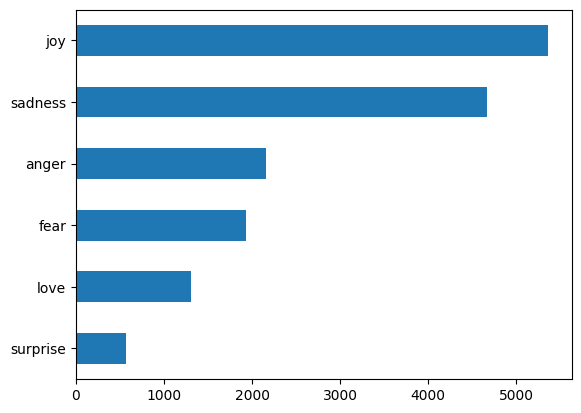

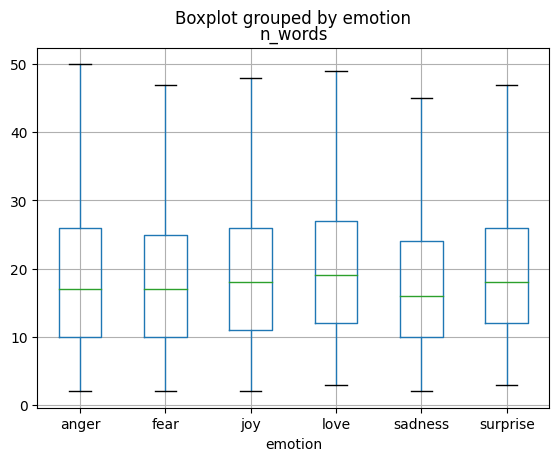

In [4]:
VIZUAL = True

# DATA
emos = load_dataset('emotion')
if VIZUAL:
    vizual.output_distribution(dataset=emos)
    # vizual.n_words(dataset=emos)

# TOKENIZER
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
None